In [1]:
import os
import random
import shutil
import cv2
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.applications.vgg16 import VGG16, preprocess_input
import numpy as np
from sklearn.manifold import TSNE
import seaborn as sns
from PIL import Image
from keras.preprocessing import image
from skimage.feature import local_binary_pattern
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import accuracy_score
import time
from keras.optimizers import Adam

In [2]:
## DATA PRE-PROCESSING & EDA
class SoilDataPreprocessor:
    """
    A class for preprocessing soil image data.
    
    Attributes:
    -----------
    data_dir : str
        Path to the directory containing the dataset.
    resize_dir : str
        Path to the directory where resized images will be stored.
    target_size : tuple
        Tuple representing the target size for resizing images.
    """
    
    def __init__(self, data_dir, resize_dir, target_size=(224, 224)):
        self.data_dir = data_dir
        self.resize_dir = resize_dir
        self.target_size = target_size
        
    def resize_and_normalize_images(self):
        """
        Resizes and normalizes images and stores them in resized_images directory.
        """
        if not os.path.exists(self.resize_dir):
            os.makedirs(self.resize_dir)
        
        classes = [dir for dir in os.listdir(self.data_dir) if os.path.isdir(os.path.join(self.data_dir, dir)) and not dir.startswith('.')]
        for class_name in classes:
            class_dir = os.path.join(self.data_dir, class_name)
            resized_class_dir = os.path.join(self.resize_dir, class_name)
            if not os.path.exists(resized_class_dir):
                os.makedirs(resized_class_dir)
            
            images = os.listdir(class_dir)
            for image_name in images:
                image_path = os.path.join(class_dir, image_name)
                image = cv2.imread(image_path)
                if image is None:  # Skip non-image files
                    continue
                resized_image = cv2.resize(image, self.target_size)
                normalized_image = resized_image / 255.0  # Normalize pixel values
                cv2.imwrite(os.path.join(resized_class_dir, image_name), normalized_image)
                
    def display_random_images(self, num_images=1):
        """
        Display random images from each class before and after resizing along with their class labels.
        """
        
        # Add random seed for reproducibility
        random.seed(42)
        
        classes = [dir for dir in os.listdir(self.data_dir) if os.path.isdir(os.path.join(self.data_dir, dir)) and not dir.startswith('.')]
        for class_name in classes:
            class_dir = os.path.join(self.data_dir, class_name)
            images = os.listdir(class_dir)
            if num_images > len(images):
                num_images = len(images)
            random_images = random.sample(images, num_images)
            
            plt.figure(figsize=(15, 3 * num_images))
            for i, image_name in enumerate(random_images):
                image_path = os.path.join(class_dir, image_name)
                image = cv2.imread(image_path)
                resized_image = cv2.resize(image, self.target_size)
                
                plt.subplot(num_images, 2, 2*i + 1)
                plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
                plt.title(f'Original - {class_name}')
                plt.axis('off')
                
                plt.subplot(num_images, 2, 2*i + 2)
                plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
                plt.title(f'Resized - {class_name}')
                plt.axis('off')
                
            plt.show()

class SoilEDA:
    """
    A class for exploratory data analysis of soil image data.
    
    Attributes:
    -----------
    data_dir : str
        Path to the directory containing the dataset.
    """
    
    def __init__(self, data_dir):
        self.data_dir = data_dir
        
    def create_eda_figures_folder():
        """
        Creates a folder named EDA_Figures for storing exploratory data analysis figures.
        If the folder exists, it overrides it.
        """
        eda_figures_dir = "EDA_Figures"
        if os.path.exists(eda_figures_dir):
            print("Warning: EDA_Figures directory already exists. Overriding...")
            os.system("rm -rf EDA_Figures")  # Delete existing directory and its contents
        os.makedirs(eda_figures_dir)
        print("EDA_Figures directory created successfully.")
    
    def display_statistics(self):
        """
        Displays the number of images, classes, and class distribution.
        """
        classes = [dir for dir in os.listdir(self.data_dir) if os.path.isdir(os.path.join(self.data_dir, dir)) and not dir.startswith('.')]
        num_images = 0
        class_distribution = Counter()
        for class_name in classes:
            class_dir = os.path.join(self.data_dir, class_name)
            images = os.listdir(class_dir)
            num_images += len(images)
            class_distribution[class_name] = len(images)
        
        # Display statistics as dataframe
        df = pd.DataFrame({'Class': list(class_distribution.keys()), 'Count': list(class_distribution.values())})
        print("Number of Images:", num_images)
        print("Number of Classes:", len(classes))
        print("\nClass Distribution:")
        print(df)
        
        # Plot class distribution
        plt.figure(figsize=(10, 6))
        plt.bar(df['Class'], df['Count'])
        plt.xlabel('Class')
        plt.ylabel('Count')
        plt.title('Class Distribution')
        for i, count in enumerate(df['Count']):
            plt.text(i, count + 10, str(count), ha='center')
        plt.xticks(rotation=45)
        plt.show()
           
    def plot_color_histograms(self):
        """
        Plots RGB color histograms for one random image per class from the given base directory.
        """
        classes = [dir for dir in os.listdir(self.data_dir) if os.path.isdir(os.path.join(self.data_dir, dir)) and not dir.startswith('.')]
        for class_name in classes:
            class_dir = os.path.join(self.data_dir, class_name)
            images = os.listdir(class_dir)
            if not images:
                continue
            random_image_name = random.choice(images)
            image_path = os.path.join(class_dir, random_image_name)
            image = cv2.imread(image_path)
            if image is None:  # Skip non-image files
                continue
            
            # Plot RGB color histogram
            colors = ('b', 'g', 'r')
            plt.figure(figsize=(8, 6))
            for i, color in enumerate(colors):
                hist = cv2.calcHist([image], [i], None, [256], [0, 256])
                plt.plot(hist, color=color)
                plt.xlim([0, 256])
            plt.title(f'RGB Color Histogram - {class_name}')
            plt.xlabel('Pixel Intensity')
            plt.ylabel('Frequency')
            plt.show()
            
    def plot_texture_patterns(self):
        """
        Plots texture patterns using Local Binary Patterns (LBP) for one random image per class.
        """
        classes = [dir for dir in os.listdir(self.data_dir) if os.path.isdir(os.path.join(self.data_dir, dir)) and not dir.startswith('.')]
        for class_name in classes:
            class_dir = os.path.join(self.data_dir, class_name)
            images = os.listdir(class_dir)
            if not images:
                continue
            random_image_name = random.choice(images)
            image_path = os.path.join(class_dir, random_image_name)
            image = cv2.imread(image_path)
            if image is None:  # Skip non-image files
                continue
            
            # Convert image to grayscale
            gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            
            # Compute Local Binary Patterns (LBP)
            radius = 3
            num_points = 8 * radius
            lbp = local_binary_pattern(gray_image, num_points, radius, method='uniform')
            
            # Plot LBP image
            plt.figure(figsize=(8, 6))
            plt.imshow(lbp, cmap='gray')
            plt.title(f'LBP Texture Pattern - {class_name}')
            plt.axis('off')
            plt.show()
            
            
    def image_quality_analysis(self):
        """
        Performs image quality analysis to detect blurry, low-resolution, and poorly-lit images for each class.
        """
        classes = [dir for dir in os.listdir(self.data_dir) if os.path.isdir(os.path.join(self.data_dir, dir)) and not dir.startswith('.')]

        for class_name in classes:
            class_dir = os.path.join(self.data_dir, class_name)
            blur_scores = []
            resolutions = []
            brightness_values = []

            images = os.listdir(class_dir)
            for image_name in images:
                image_path = os.path.join(class_dir, image_name)
                image = cv2.imread(image_path)
                if image is None:  # Skip non-image files
                    continue

                # Calculate image quality metrics
                blur_score = cv2.Laplacian(image, cv2.CV_64F).var()
                resolution = image.shape[0] * image.shape[1]
                brightness = np.mean(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))

                # Append metrics to lists for visualization
                blur_scores.append(blur_score)
                resolutions.append(resolution)
                brightness_values.append(brightness)

            # Plot histograms for image quality metrics
            plt.figure(figsize=(10, 8))
            plt.subplot(3, 1, 1)
            plt.hist(blur_scores, bins=20, color='blue', alpha=0.7)
            plt.title(f'Blur Score Distribution for {class_name}')
            plt.xlabel('Blur Score')
            plt.ylabel('Frequency')

            plt.subplot(3, 1, 2)
            plt.hist(resolutions, bins=20, color='green', alpha=0.7)
            plt.title(f'Resolution Distribution for {class_name}')
            plt.xlabel('Resolution')
            plt.ylabel('Frequency')

            plt.subplot(3, 1, 3)
            plt.hist(brightness_values, bins=20, color='red', alpha=0.7)
            plt.title(f'Brightness Distribution for {class_name}')
            plt.xlabel('Brightness')
            plt.ylabel('Frequency')

            plt.tight_layout()
            plt.show()

    def brightness_distribution_boxplot(self):
        """
        Plots the brightness distribution boxplot for each class.
        """
        classes = [dir for dir in os.listdir(self.data_dir) if os.path.isdir(os.path.join(self.data_dir, dir)) and not dir.startswith('.')]
        brightness_data = {class_name: [] for class_name in classes}

        # Collect brightness values for each class
        for class_name in classes:
            class_dir = os.path.join(self.data_dir, class_name)
            images = os.listdir(class_dir)
            for image_name in images:
                image_path = os.path.join(class_dir, image_name)
                image = cv2.imread(image_path)
                if image is not None:  # Process only valid images
                    brightness = np.mean(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))
                    brightness_data[class_name].append(brightness)

        # Create box plots for each class distribution
        plt.figure(figsize=(12, 8))
        boxplot_data = [brightness_data[class_name] for class_name in classes]
        plt.boxplot(boxplot_data, labels=classes)
        plt.title('Brightness Distribution for Each Class')
        plt.xlabel('Class')
        plt.ylabel('Brightness')
        plt.show()


class DatasetSplitter:
    """
    A class for splitting the dataset into train-test-validation sets.
    
    Attributes:
    -----------
    dataset_dir : str
        Path to the directory containing the dataset.
    train_dir : str
        Path to the directory where the training set will be stored.
    test_dir : str
        Path to the directory where the test set will be stored.
    validation_dir : str
        Path to the directory where the validation set will be stored.
    resize_dir : str
        Path to the directory where resized images are stored.
    target_size : tuple
        Tuple representing the target size for resizing images.
    """
    
    def __init__(self, dataset_dir, train_dir, test_dir, validation_dir, resize_dir, target_size=(100, 100)):
        self.dataset_dir = dataset_dir
        self.train_dir = train_dir
        self.test_dir = test_dir
        self.validation_dir = validation_dir
        self.resize_dir = resize_dir
        self.target_size = target_size
        
    def split_dataset(self, split_ratio=(0.85, 0.075, 0.075)):
        """
        Splits the dataset into train-test-validation sets.

        Parameters:
        -----------
        split_ratio : tuple
            A tuple representing the ratio for train-test-validation split. Default is (0.7, 0.15, 0.15).
        """
        # Create directories if they don't exist
        for directory in [self.train_dir, self.test_dir, self.validation_dir]:
            if not os.path.exists(directory):
                os.makedirs(directory)

        # Get list of classes
        classes = [dir for dir in os.listdir(self.dataset_dir) if os.path.isdir(os.path.join(self.dataset_dir, dir))]

        # Split dataset for each class
        for class_name in classes:
            class_dir = os.path.join(self.dataset_dir, class_name)
            train_class_dir = os.path.join(self.train_dir, class_name)
            test_class_dir = os.path.join(self.test_dir, class_name)
            validation_class_dir = os.path.join(self.validation_dir, class_name)

            # Create class directories in train, test, and validation directories
            for directory in [train_class_dir, test_class_dir, validation_class_dir]:
                if not os.path.exists(directory):
                    os.makedirs(directory)

            # Get list of images for the current class
            images = os.listdir(class_dir)

            # Split images into train, test, and validation sets
            train_images, test_validation_images = train_test_split(images, test_size=split_ratio[1] + split_ratio[2], random_state=42)
            test_images, validation_images = train_test_split(test_validation_images, test_size=split_ratio[2] / (split_ratio[1] + split_ratio[2]), random_state=42)

            # Copy images to respective directories
            for image_name in train_images:
                src = os.path.join(self.resize_dir, class_name, image_name)
                dst = os.path.join(train_class_dir, image_name)
                shutil.copyfile(src, dst)

            for image_name in test_images:
                src = os.path.join(self.resize_dir, class_name, image_name)
                dst = os.path.join(test_class_dir, image_name)
                shutil.copyfile(src, dst)

            for image_name in validation_images:
                src = os.path.join(self.resize_dir, class_name, image_name)
                dst = os.path.join(validation_class_dir, image_name)
                shutil.copyfile(src, dst)

        # Display count of images in each set
        for directory, set_name in zip([self.train_dir, self.test_dir, self.validation_dir], ["Train", "Test", "Validation"]):
            total_count = 0
            for class_name in classes:
                class_dir = os.path.join(directory, class_name)
                count = len(os.listdir(class_dir))
                print(f"{set_name} set - Class: {class_name}, Count: {count}")
                total_count += count
            print(f"Total {set_name} set images: {total_count}\n\n")
           
        
    def augment_train_data(self, augment_params={}):
        """
        Apply data augmentation techniques to the training set.

        Parameters:
        -----------
        augment_params : dict
            Dictionary containing parameters for data augmentation. Refer to Keras documentation for available parameters.
        """
        # Add additional augmentation parameters
        augment_params['rotation_range'] = augment_params.get('rotation_range', 40)
        augment_params['width_shift_range'] = augment_params.get('width_shift_range', 0.2)
        augment_params['height_shift_range'] = augment_params.get('height_shift_range', 0.2)
        augment_params['shear_range'] = augment_params.get('shear_range', 0.2)
        augment_params['zoom_range'] = augment_params.get('zoom_range', 0.2)
        augment_params['horizontal_flip'] = augment_params.get('horizontal_flip', True)
        augment_params['vertical_flip'] = augment_params.get('vertical_flip', True)
        augment_params['brightness_range'] = augment_params.get('brightness_range', (0.5, 1.5))
        
        train_datagen = ImageDataGenerator(**augment_params)
        
        # Generate augmented images and save them to the train directory
        train_generator = train_datagen.flow_from_directory(
            self.train_dir,
            target_size=self.target_size,
            batch_size=32,
            class_mode='categorical',
            save_to_dir=self.train_dir,
            save_prefix='augmented',
            save_format='jpeg'
        )

        # Calculate number of batches
        num_batches = len(train_generator)
        print(f"Number of batches generated: {num_batches}")

        # Display class distribution of augmented images
        augmented_class_distribution = Counter(train_generator.classes)
        print("Class Distribution of Augmented Images:")
        for class_name, count in augmented_class_distribution.items():
            print(f"Class: {class_name}, Count: {count}")

        # Display total number of images in training set after data augmentation
        total_train_images = sum(augmented_class_distribution.values())
        print(f"Total number of images in training set after data augmentation: {total_train_images}\n\n")
        
        
class SoilFeatureExtractor:
    """
    A class for extracting features from soil images using pre-trained VGG16 model.
    
    Attributes:
    -----------
    data_dir : str
        Path to the directory containing the dataset.
    vgg_model : keras.Model
        Pre-trained VGG16 model.
    """
    
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(100, 100, 3))
        
    def extract_features(self):
        """
        Extract features from soil images using the pre-trained VGG16 model.
        
        Returns:
        --------
        features : numpy.ndarray
            Extracted features.
        labels : numpy.ndarray
            Corresponding class labels.
        """
        features = []
        labels = []
        
        # Loop through each class directory
        classes = [dir for dir in os.listdir(self.data_dir) if not dir.startswith('.')]
        for class_name in classes:
            class_dir = os.path.join(self.data_dir, class_name)
            
            # Ensure that the directory is indeed a directory
            if not os.path.isdir(class_dir):
                continue
            
            # Loop through each image in the class directory
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                
                # Skip if it's not a file (e.g., a directory)
                if not os.path.isfile(img_path):
                    continue
                
                img = image.load_img(img_path, target_size=(100, 100))
                img = image.img_to_array(img)
                img = np.expand_dims(img, axis=0)
                img = preprocess_input(img)
                
                # Extract features using the VGG16 model
                features.append(self.vgg_model.predict(img).flatten())
                labels.append(class_name)
        
        features = np.array(features)
        labels = np.array(labels)
        
        return features, labels
    
    


## DATA PRE-PROCESSING & EDA

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB


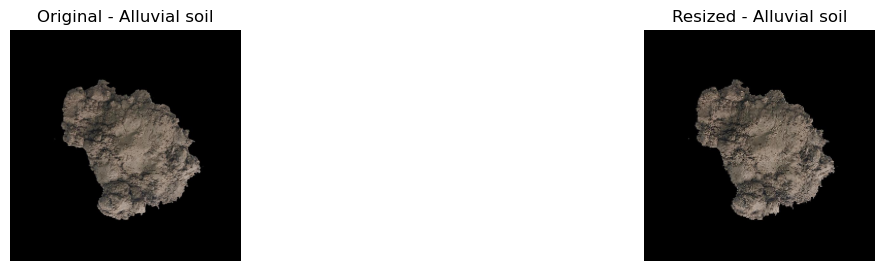

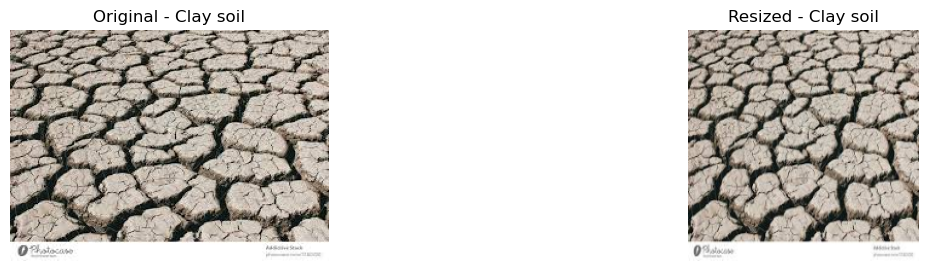

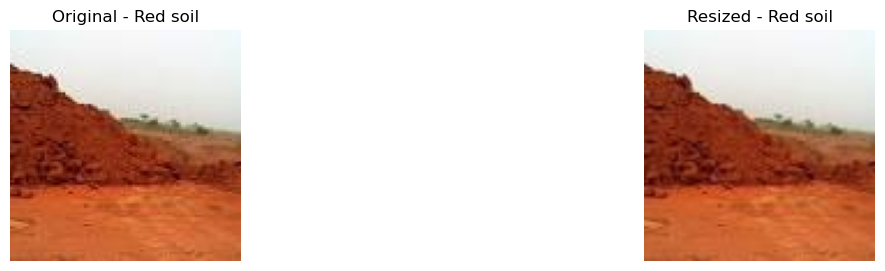

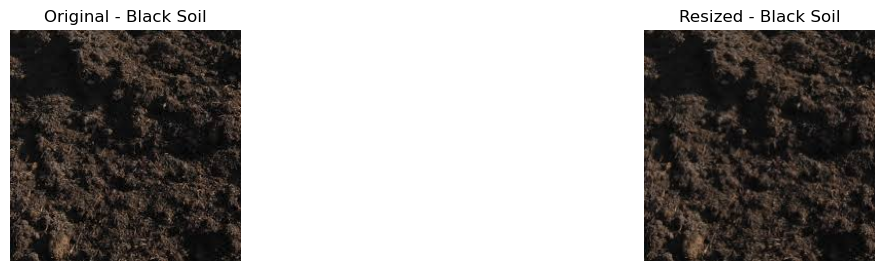

Number of Images: 1292
Number of Classes: 4

Class Distribution:
           Class  Count
0  Alluvial soil    534
1      Clay soil    226
2       Red soil    267
3     Black Soil    265


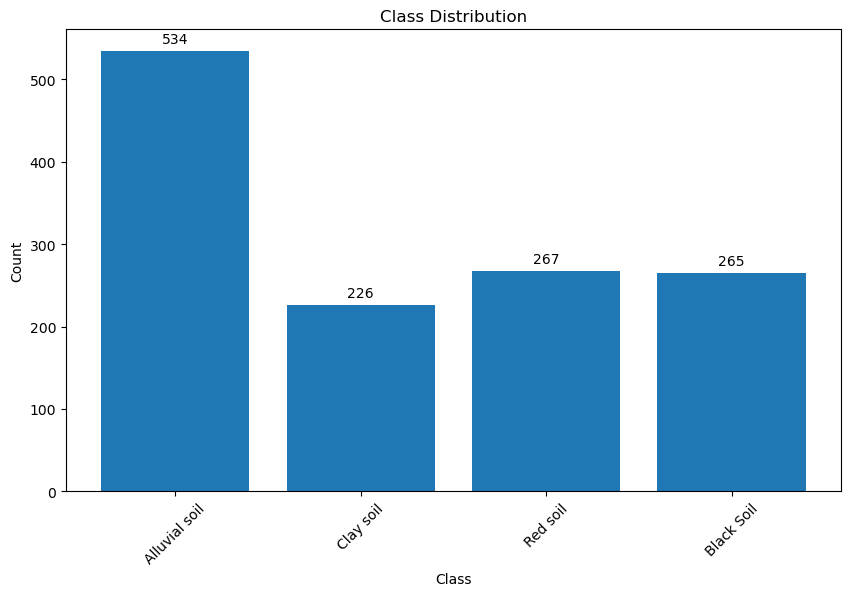

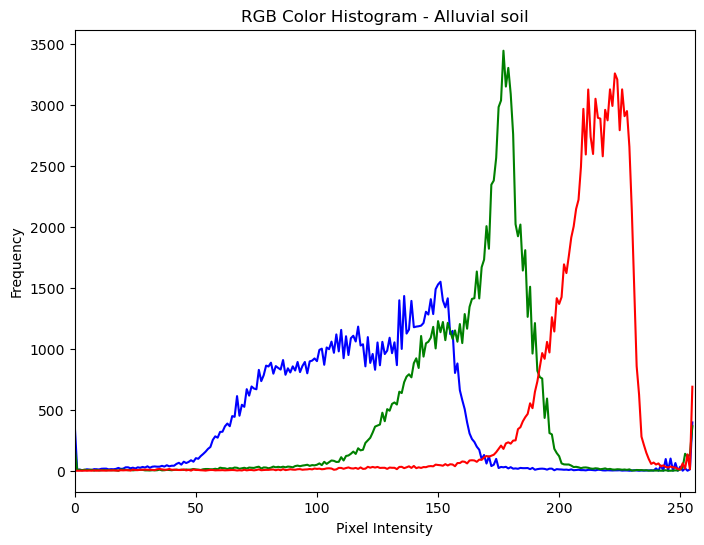

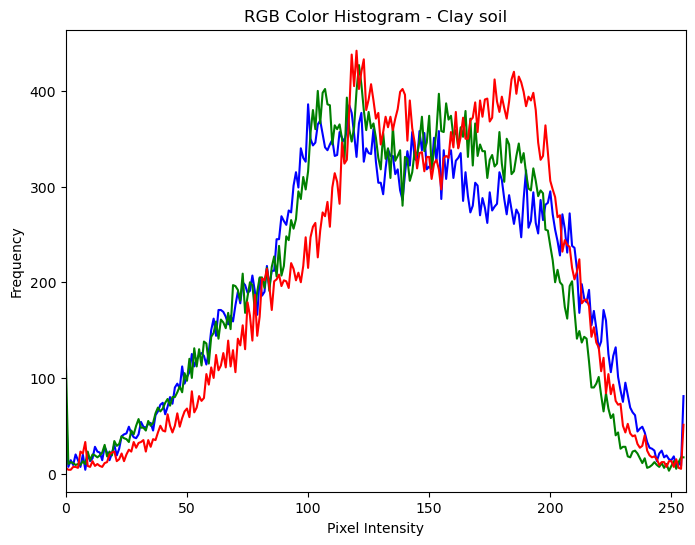

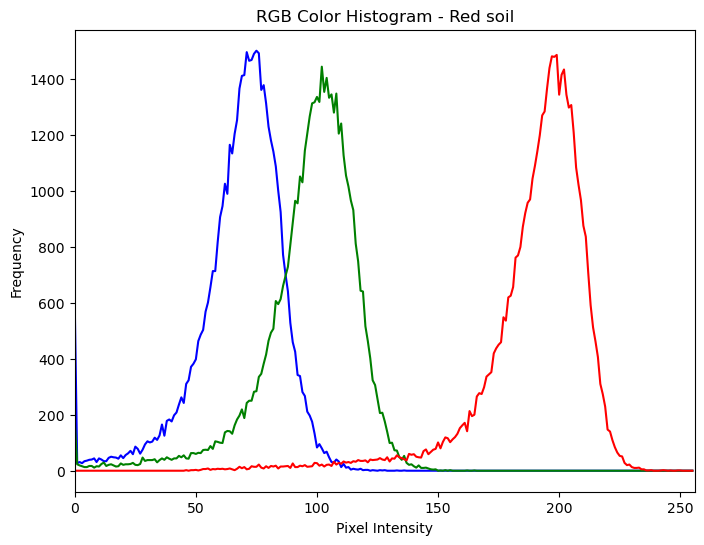

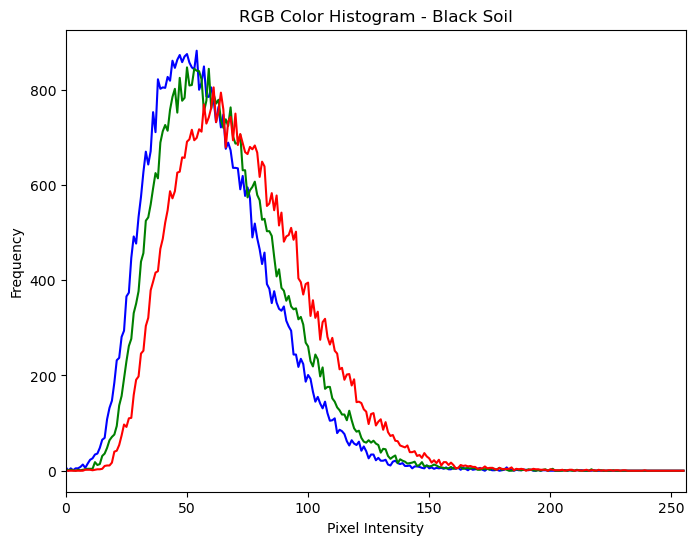

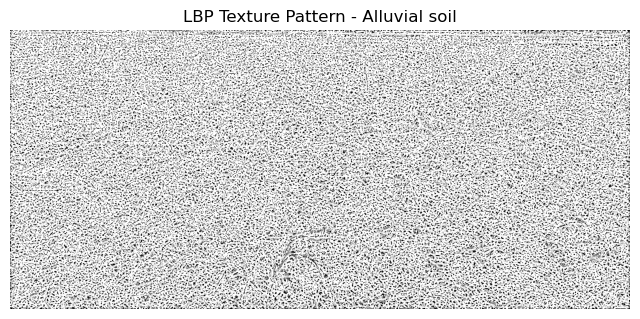

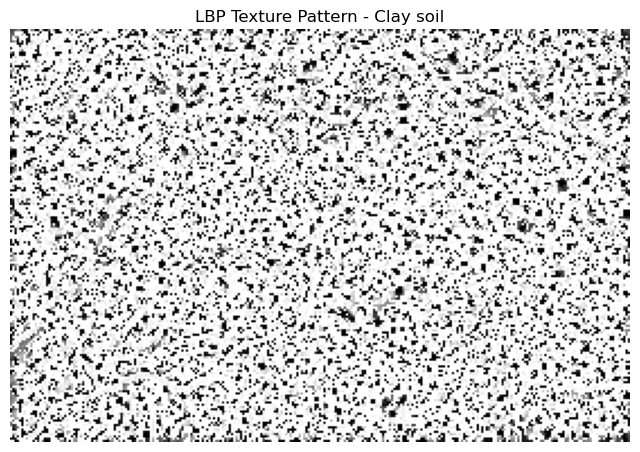

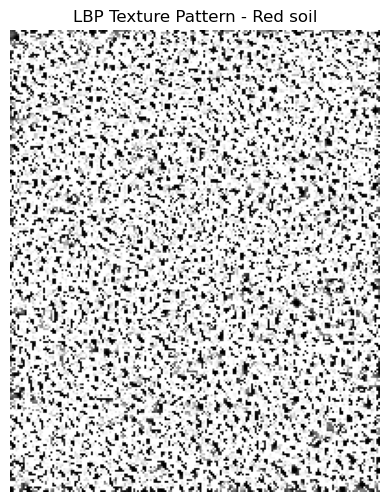

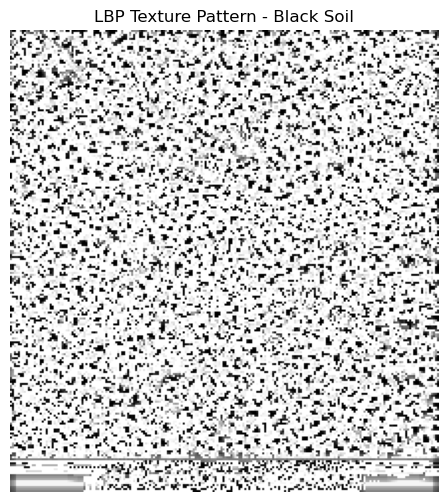

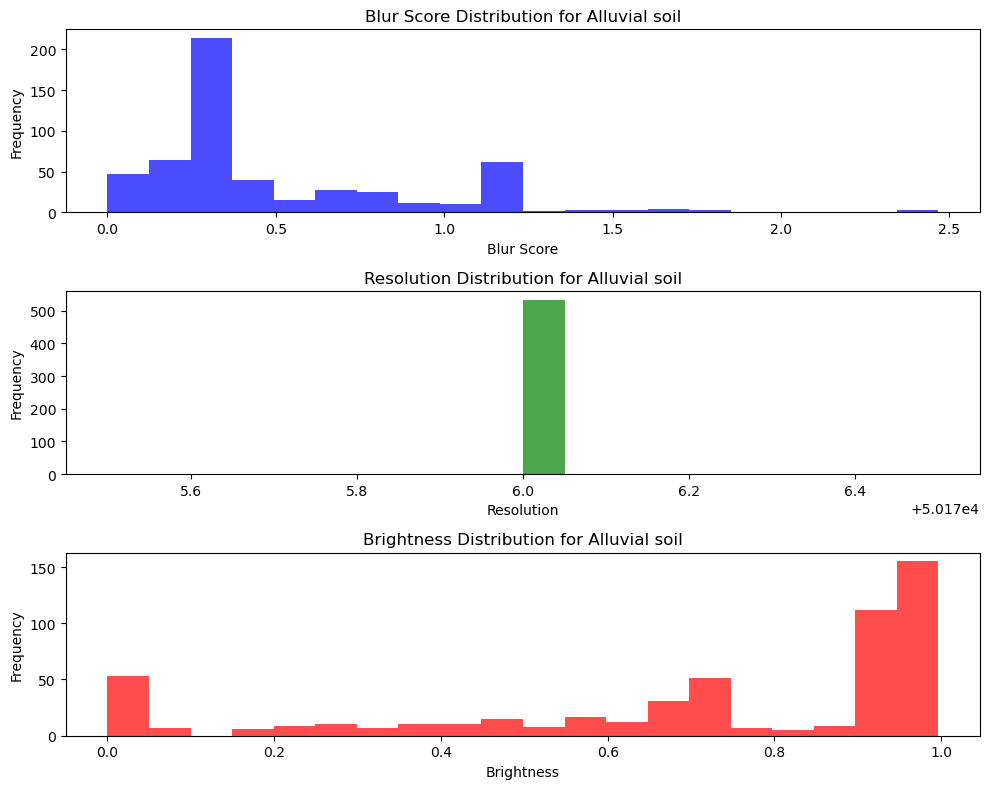

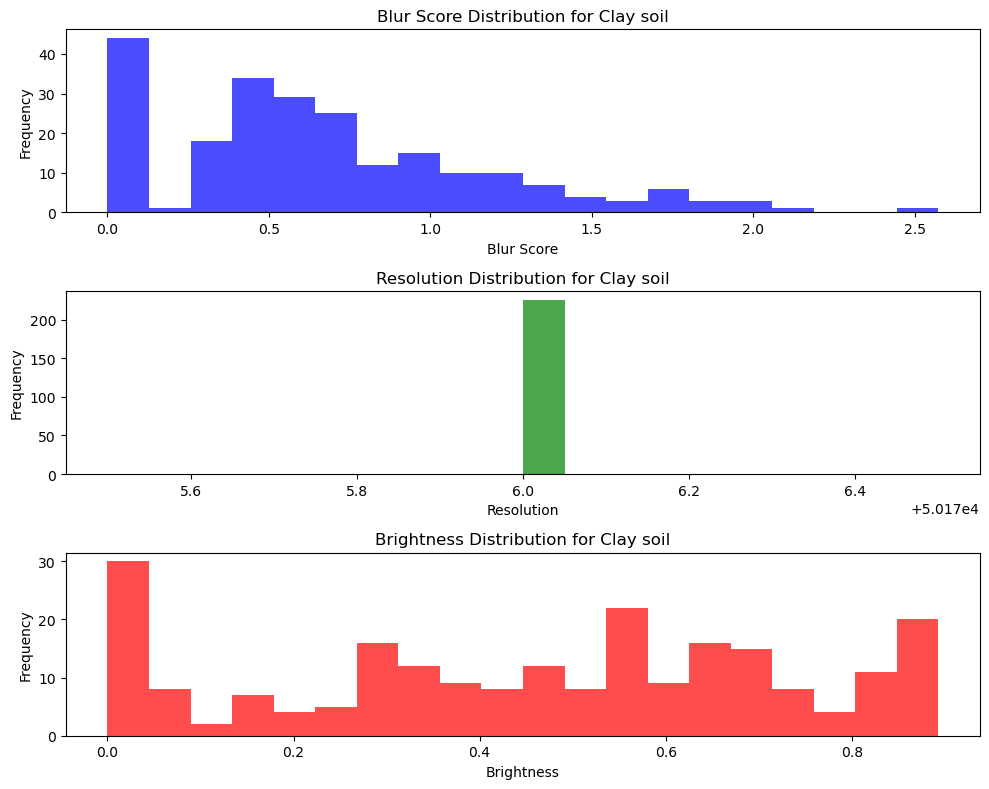

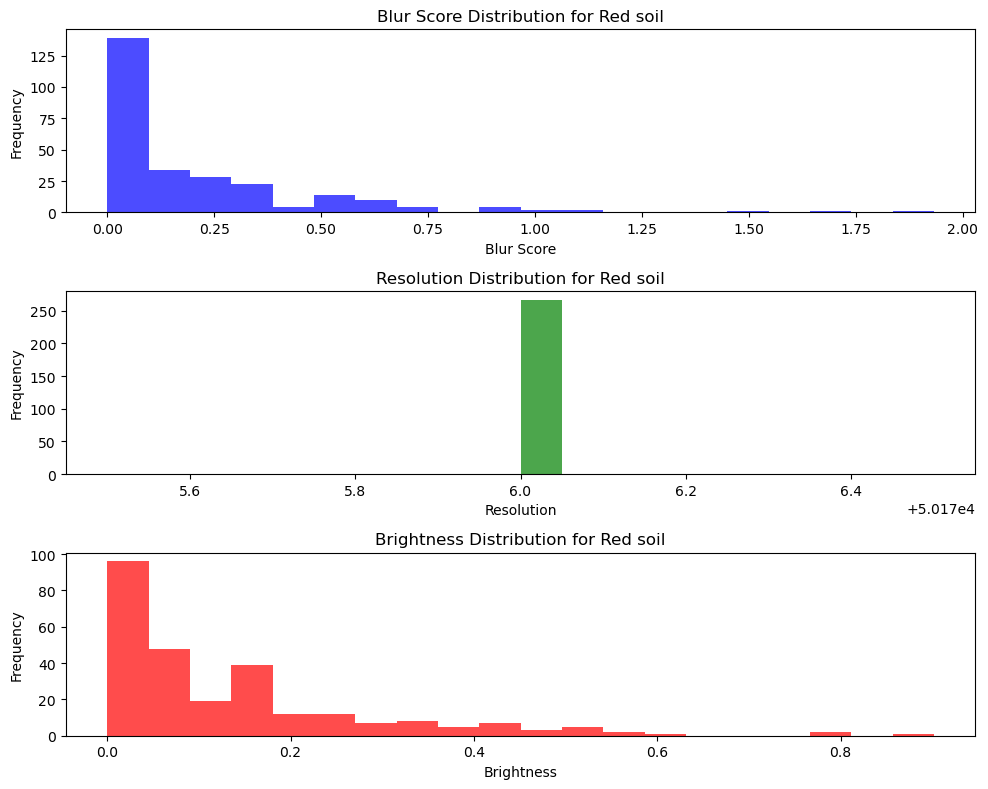

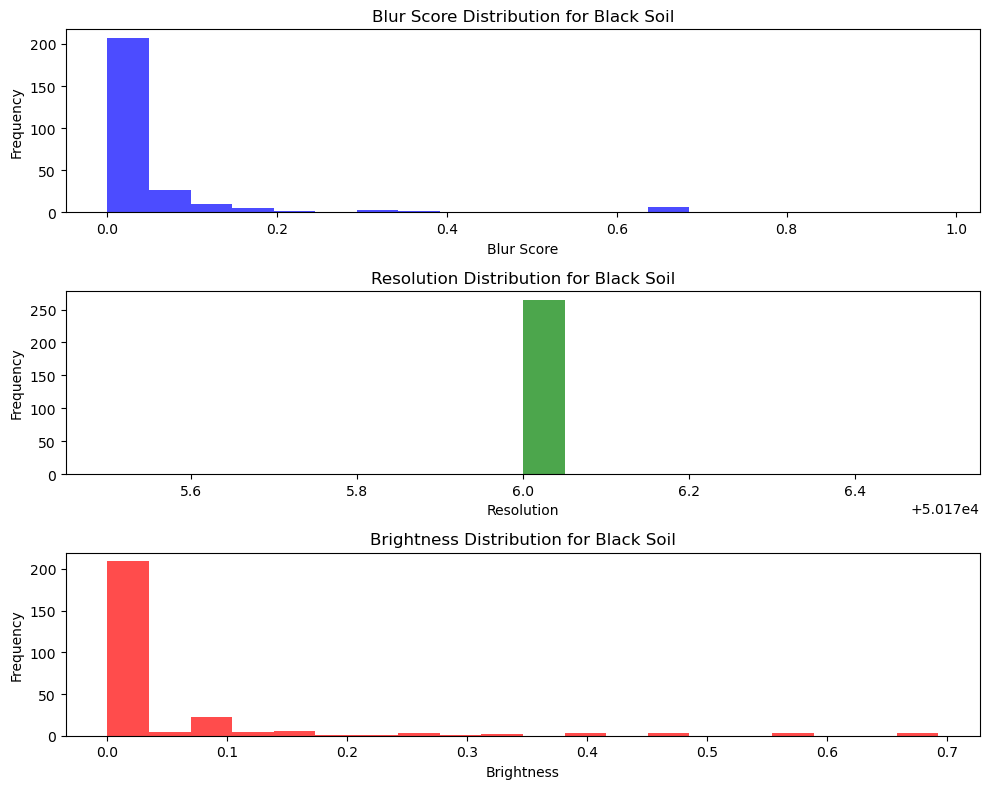

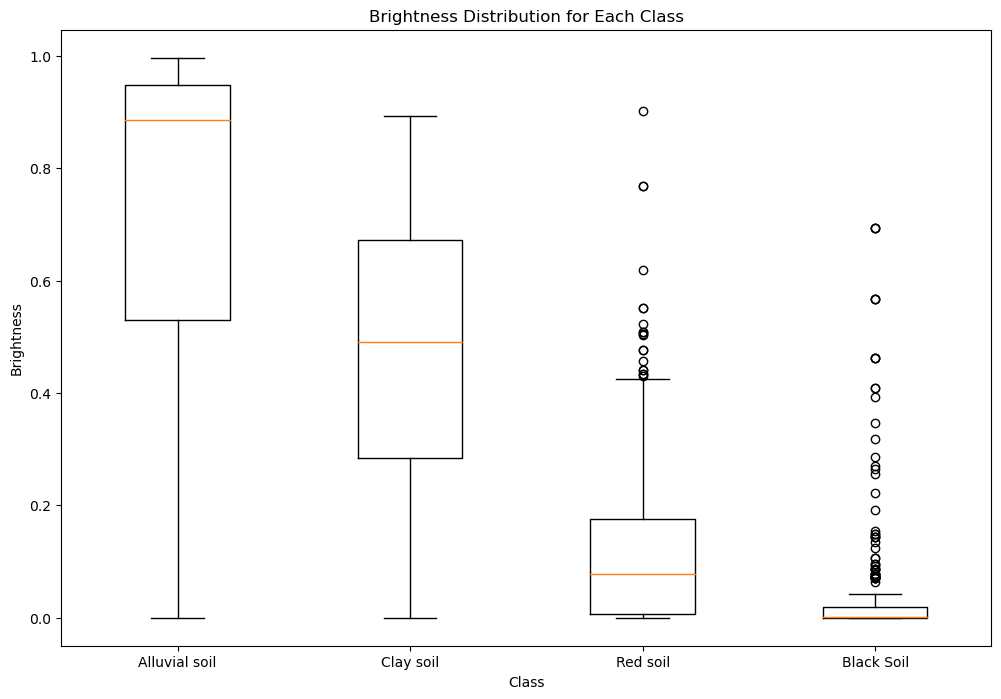

Train set - Class: Alluvial soil, Count: 453
Train set - Class: Clay soil, Count: 192
Train set - Class: Red soil, Count: 226
Train set - Class: Black Soil, Count: 225
Total Train set images: 1096


Test set - Class: Alluvial soil, Count: 40
Test set - Class: Clay soil, Count: 17
Test set - Class: Red soil, Count: 20
Test set - Class: Black Soil, Count: 20
Total Test set images: 97


Validation set - Class: Alluvial soil, Count: 41
Validation set - Class: Clay soil, Count: 17
Validation set - Class: Red soil, Count: 21
Validation set - Class: Black Soil, Count: 20
Total Validation set images: 99


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 30ms/step


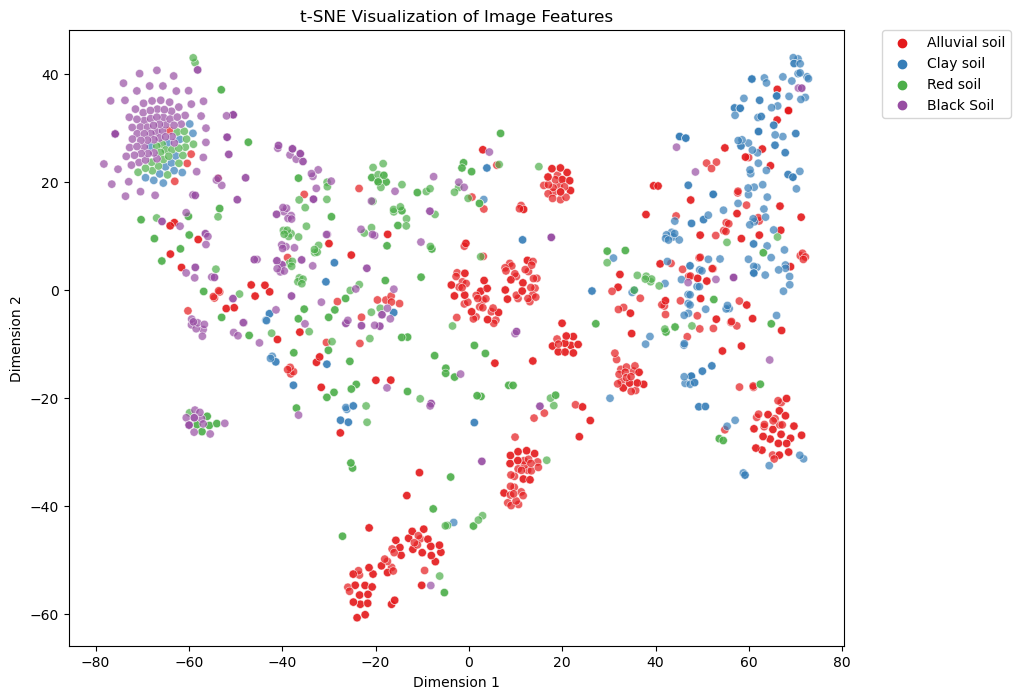

Found 1096 images belonging to 4 classes.
Number of batches generated: 35
Class Distribution of Augmented Images:
Class: 0, Count: 453
Class: 1, Count: 225
Class: 2, Count: 192
Class: 3, Count: 226
Total number of images in training set after data augmentation: 1096




In [3]:
if __name__ == "__main__":
    
    # Set random seeds for reproducibility
    random.seed(42)
    np.random.seed(42)
    tf.random.set_seed(42)
    os.environ['PYTHONHASHSEED'] = '42'
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    
    # Data preprocessing
    data_dir = "Soil Dataset Merged"
    resize_dir = "resized_images"
    preprocessor = SoilDataPreprocessor(data_dir, resize_dir)
    preprocessor.resize_and_normalize_images()

    # Display random images from each class before and after resizing
    preprocessor.display_random_images()

    # EDA
    eda = SoilEDA(resize_dir)
    eda.display_statistics()

    # Call the method to plot color histograms
    data_eda = SoilEDA(data_dir='Soil Dataset Merged')
    data_eda.plot_color_histograms()

    # Call the method to plot texture patterns
    data_eda.plot_texture_patterns()

    # Image quality analysis
    eda.image_quality_analysis()

    # Outlier detection
    eda.brightness_distribution_boxplot()

    # Split dataset into train-test-validation sets
    dataset_splitter = DatasetSplitter(dataset_dir=data_dir,
                                   train_dir='train_test_val/train',
                                   test_dir='train_test_val/test',
                                   validation_dir='train_test_val/validation',
                                   resize_dir=resize_dir)

    dataset_splitter.split_dataset()

    # Feature extraction
    data_dir = 'resized_images'
    feature_extractor = SoilFeatureExtractor(data_dir)
    features, labels = feature_extractor.extract_features()

    # Perform t-SNE dimensionality reduction
    tsne = TSNE(n_components=2, random_state=42)
    tsne_features = tsne.fit_transform(features)

    # Create a DataFrame for visualization
    tsne_df = pd.DataFrame(tsne_features, columns=['Dimension 1', 'Dimension 2'])
    tsne_df['Class'] = labels

    # Plot t-SNE visualization
    plt.figure(figsize=(10, 8))
    sns.scatterplot(data=tsne_df, x='Dimension 1', y='Dimension 2', hue='Class', palette='Set1', alpha=0.7)
    plt.title('t-SNE Visualization of Image Features')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

    # Augment training data
    augment_params = {'rotation_range': 40, 'width_shift_range': 0.2, 'height_shift_range': 0.2,
                      'shear_range': 0.2, 'zoom_range': 0.2, 'horizontal_flip': True, 'vertical_flip': True,
                      'brightness_range': (0.5, 1.5)}
    dataset_splitter.augment_train_data(augment_params)